# Coffee Lovers Unite!

If caffeine is one of the most popular drugs, then coffee is likely one of the most popular delivery systems for it. Aside from caffeine, people enjoy the wonderful variety of coffee-related drinks. Let’s do a rough investigation of the “market share” by two of the top coffee chains in the United States!

World Population Review provides some great data on store locations and chain prevalence. Check out this page for the Starbucks Coffee locations in the United States. Notice that this page only really gives the name of the state and the number of locations in that state.

# Scrape the Location Counts

In [35]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from plotnine import *

## 1. Use the beautifulsoup library to scrape the data (from the link above) on state names and corresponding number of store locations, for the following chains:

- Starbucks

- Dunkin’ Donuts

## 2. Parse, merge and tidy your data. Think carefully about what the tidy version of this dataset is with multiple years represented on the website.

# Automate

In [36]:

def scrape_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    #locate the table
    table = soup.find("table", class_="wpr-table")
    
    #initialize
    headers = []
    rows = []
    states_list = []
    
    #header names
    for th in table.find_all("th", class_="datatable-th"):
        header = th.get_text(strip=True)
        headers.append(header)
    
    #state names
    for th in table.find_all("th")[len(headers):]:
        state = th.get_text(strip=True)
        states_list.append(state)

    #loop through the rows
    for i, tr in enumerate(table.find_all("tr")[1:]): 
        state = states_list[i] if i < len(states_list) else None
        cells = tr.find_all("td")
        row_data = {"State": state}

        #populate with cell data
        for j, cell in enumerate(cells):
            cell_tag = cell.find("a") or cell
            row_data[headers[j + 1]] = cell_tag.get_text(strip=True)

        #append
        rows.append(row_data)
    
    #create dataframe
    df = pd.DataFrame(rows)
    #make long
    df_long = df.melt(id_vars='State', var_name='Year', value_name='Count')
    df_long['Store'] = df_long['Year'].apply(lambda x: x.split()[0])  # Take the first word as Store name
    df_long['Year'] = df_long['Year'].apply(lambda x: re.search(r'(\d{4})', x).group(0) if re.search(r'(\d{4})', x) else None)

    return df_long

#testing the function
chick_fil_a_df = scrape_table("https://worldpopulationreview.com/state-rankings/chick-fil-a-by-state")
chick_fil_a_df.head()


,State,Year,Count,Store
0,Texas,2024,489,Chick-Fil-A
1,Florida,2024,334,Chick-Fil-A
2,Georgia,2024,327,Chick-Fil-A
3,California,2024,243,Chick-Fil-A
4,North Carolina,2024,174,Chick-Fil-A


In [37]:
#scrape dunkin and starbucks data
dunkin_long = scrape_table("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")
starbucks_long = scrape_table("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")

#merging
combined_df = pd.concat([dunkin_long, starbucks_long], ignore_index=True)
combined_df = combined_df[['State', 'Year', 'Store', 'Count']].sort_values(by=['State', 'Year', 'Store']).reset_index(drop=True)

# Supplemental Data

## 4. Scrape the state names and populations from this wikipedia page. Merge these data with your coffee dataset.

In [38]:
#scrape the data
population = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")
population_soup = BeautifulSoup(population.content, "html.parser")

#find the table
population_table = population_soup.find('table', class_ = 'wikitable sortable')
pop_rows = []

#iterate over rows
for tr in population_table.find_all("tr")[1:]:
    cells = tr.find_all('td')
    if len(cells) >= 3:
        state = cells[2].get_text(strip=True)
        population = cells[3].get_text(strip=True)
        
        #append
        pop_rows.append({
            "State": state,
            "Population": population
        })

#convert to dataframe
pop_df = pd.DataFrame(pop_rows)

#merge
combined_df = pd.merge(combined_df, pop_df, on="State", how="outer")

## 5. Find the revenue, stock price, or your financial metric of choice for each of the companies listed above (if you can find a website to scrape these from that’s great!…but it’s okay if you manually enter these). Merge these values into your big dataset. Note: these values may be repeated for each state.

In [39]:
#create stock price data
stock_prices = {
    "Store": ["Starbucks", "Starbucks", "Starbucks", "Dunkin", "Dunkin"],
    "Year": [2021, 2023, 2024, 2023, 2024],
    "Stock Price": [116.97, 96.01, 97.31, 106.48, 106.48]
}

#convert to dataframe
stock_prices_df = pd.DataFrame(stock_prices)

#make sure column types are the same and drop na
combined_df.dropna(subset=["Year"], inplace=True)
combined_df["Year"] = combined_df["Year"].astype(int)
stock_prices_df["Year"] = stock_prices_df["Year"].astype(int)

#merge
merged_df = pd.merge(combined_df, stock_prices_df, on=["Store", "Year"], how="left")

## 6. Create a region variable in your dataset according to the scheme on this wikipedia page: Northeast, Midwest, South, West. You do not need to scrape this information.

In [40]:
#use website classifications
state_to_region = {
    "Connecticut": "Northeast",
    "Maine": "Northeast",
    "Massachusetts": "Northeast",
    "New Hampshire": "Northeast",
    "Rhode Island": "Northeast",
    "Vermont": "Northeast",
    "New Jersey": "Northeast",
    "New York": "Northeast",
    "Pennsylvania": "Northeast",
    "Illinois": "Midwest",
    "Indiana": "Midwest",
    "Michigan": "Midwest",
    "Ohio": "Midwest",
    "Wisconsin": "Midwest",
    "Iowa": "Midwest",
    "Kansas": "Midwest",
    "Minnesota": "Midwest",
    "Missouri": "Midwest",
    "Nebraska": "Midwest",
    "North Dakota": "Midwest",
    "South Dakota": "Midwest",
    "Delaware": "South",
    "Florida": "South",
    "Georgia": "South",
    "Maryland": "South",
    "North Carolina": "South",
    "South Carolina": "South",
    "Virginia": "South",
    "Washington, D.C.": "South",
    "West Virginia": "South",
    "Alabama": "South",
    "Kentucky": "South",
    "Mississippi": "South",
    "Tennessee": "South",
    "Arkansas": "South",
    "Louisiana": "South",
    "Oklahoma": "South",
    "Texas": "South",
    "District of Columbia" : "South",
    "Arizona": "West",
    "Colorado": "West",
    "Idaho": "West",
    "Montana": "West",
    "Nevada": "West",
    "New Mexico": "West",
    "Utah": "West",
    "Wyoming": "West",
    "Alaska": "West",
    "California": "West",
    "Hawaii": "West",
    "Oregon": "West",
    "Washington": "West"
}

#map
merged_df['Region'] = merged_df['State'].map(state_to_region)

# Analyze

## 7. Assess and comment on the prevalence of each chain. Some questions to consider (you don’t need to answer all of these and you may come up with your own)

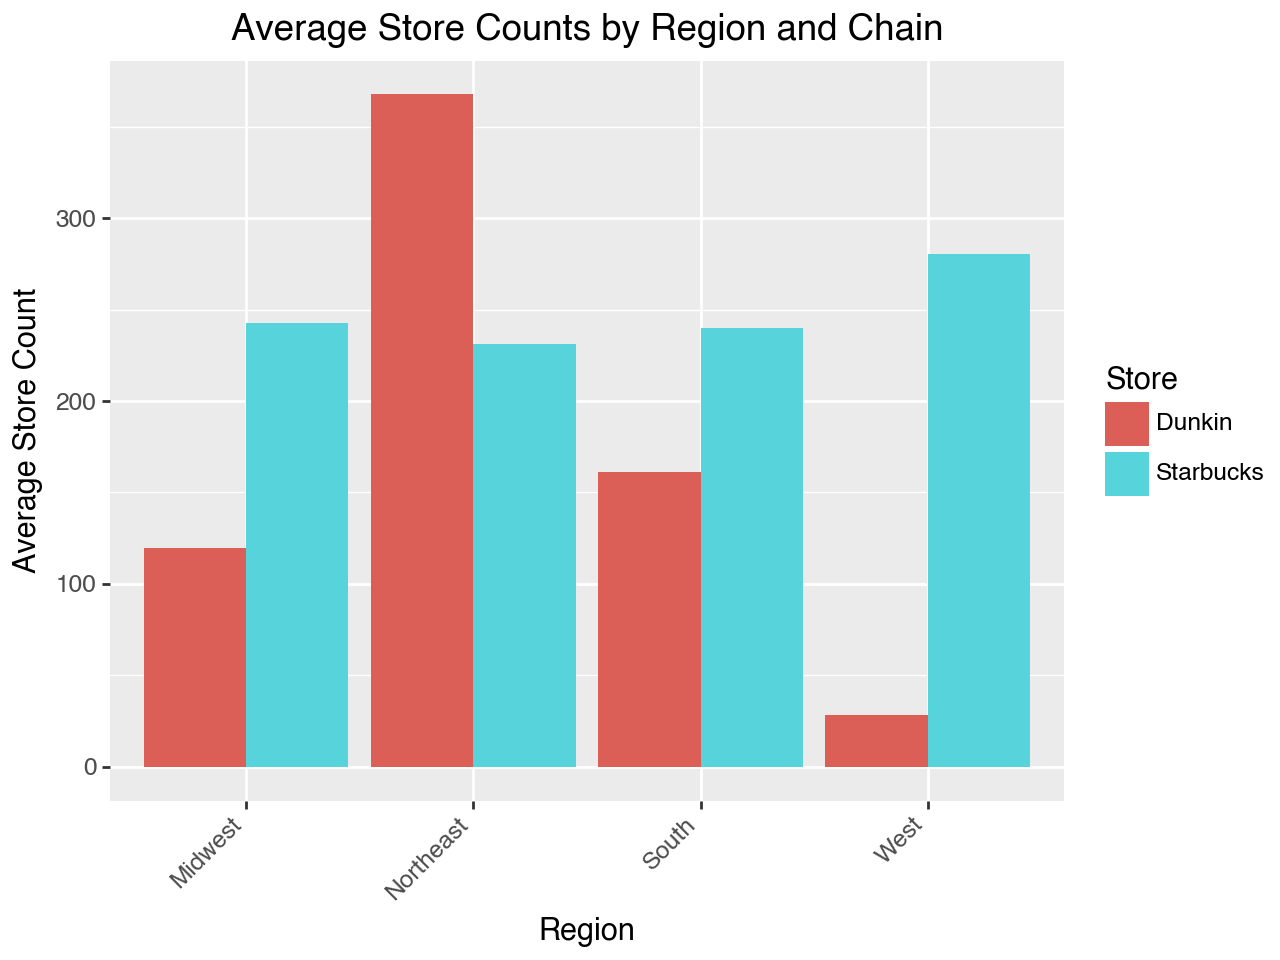

In [41]:
#convert count to numeric
merged_df['Count'] = pd.to_numeric(merged_df['Count'], errors='coerce')

#mean store counts for each region
region_summary_df = merged_df.groupby(['Region', 'Store'])['Count'].mean().reset_index()

#create bar chart
(ggplot(region_summary_df, aes(x='Region', y='Count', fill='Store'))
    + geom_bar(stat='identity', position='dodge')
    + labs(title="Average Store Counts by Region and Chain", 
            y="Average Store Count", 
            x="Region")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

### Average Store Prevalence by Region

The bar chart comparing average store counts by region and chain shows notable regional differences in the distribution of Dunkin' and Starbucks locations:

Starbucks has a larger presence in every region except the Northeast, where Dunkin’ has a stronger presence due to its popularity in states like New York and other Northeastern areas. Dunkin' has a comparatively minimal presence in the West. This disparity could suggest a market opportunity or regional brand preference that Starbucks is capitalizing on.

/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 53 rows containing non-finite values.


/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 53 rows containing missing values.


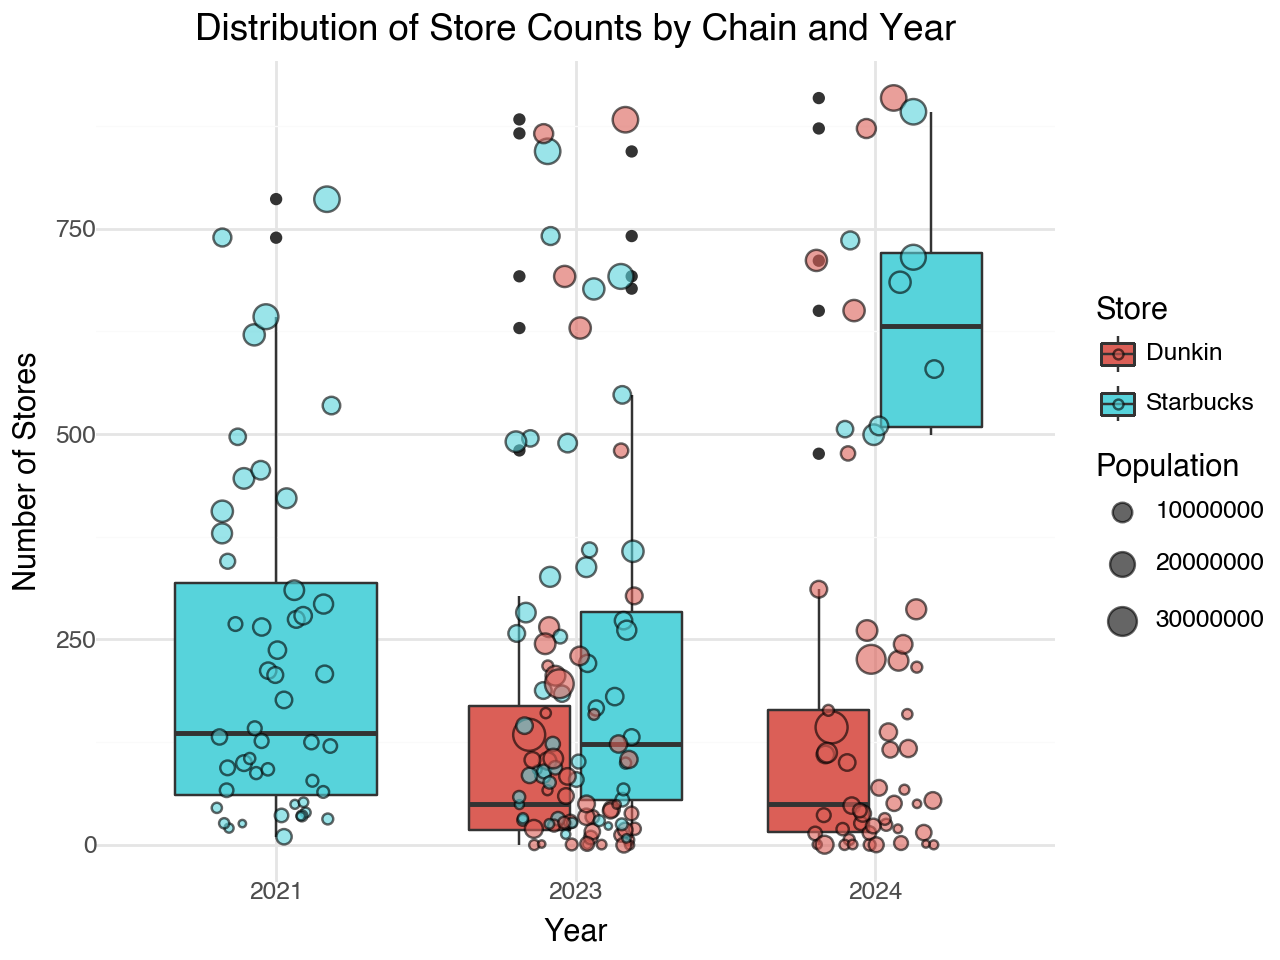

In [42]:
#make year categorical and population numeric
merged_df['Year'] = pd.Categorical(merged_df['Year'])
merged_df['Population'] = merged_df['Population'].str.replace(',', '').astype(float)
(ggplot(merged_df, aes(x='Year', y='Count', fill='Store')) 
        + geom_boxplot(outlier_shape=None)
        + geom_jitter(aes(size='Population'), width=0.2, color='black', alpha=0.6)
        + labs(title='Distribution of Store Counts by Chain and Year', 
               x='Year', 
               y='Number of Stores')
        + theme_minimal())

In [43]:
#summary statistics
summary_stats = merged_df.groupby(['Year', 'Store'])['Count'].agg(
    mean='mean',
    std_dev='std',
    min='min',
    max='max'
).reset_index()
print(summary_stats)

   Year      Store        mean     std_dev    min    max
0  2021     Dunkin         NaN         NaN    NaN    NaN
1  2021  Starbucks  223.708333  204.253697   10.0  786.0
2  2023     Dunkin  143.312500  216.813397    0.0  883.0
3  2023  Starbucks  210.571429  214.291274    8.0  844.0
4  2024     Dunkin  146.795918  219.909733    0.0  909.0
5  2024  Starbucks  640.250000  140.827909  499.0  892.0
   Year      Store        mean     std_dev    min    max
0  2021     Dunkin         NaN         NaN    NaN    NaN
1  2021  Starbucks  223.708333  204.253697   10.0  786.0
2  2023     Dunkin  143.312500  216.813397    0.0  883.0
3  2023  Starbucks  210.571429  214.291274    8.0  844.0
4  2024     Dunkin  146.795918  219.909733    0.0  909.0
5  2024  Starbucks  640.250000  140.827909  499.0  892.0


<positron-console-cell-43>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### Distribution of Store Counts Over Time

The boxplot for store counts by chain and year offers insights into how store counts vary within each year:

Starbucks shows consistent growth over time, particularly highlighted by a substantial increase in 2024. The mean and standard deviation statistics support this, with Starbucks' mean store count growing significantly from 2023 to 2024.

Dunkin’s store count has fluctuations with a wider spread across years, suggesting it has fewer locations overall with greater variability.
The summary statistics show that Dunkin's mean store counts are notably lower than Starbucks in each year, with more variation, indicating Dunkin’s potentially more limited expansion or regional strategy.

Outliers are present for both chains across different years, which could indicate areas where these brands are either over- or under-represented relative to the mean. For example, Starbucks in 2023 has a large spread, suggesting expansion in areas beyond their typical distribution.

/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 4 rows containing non-finite values.


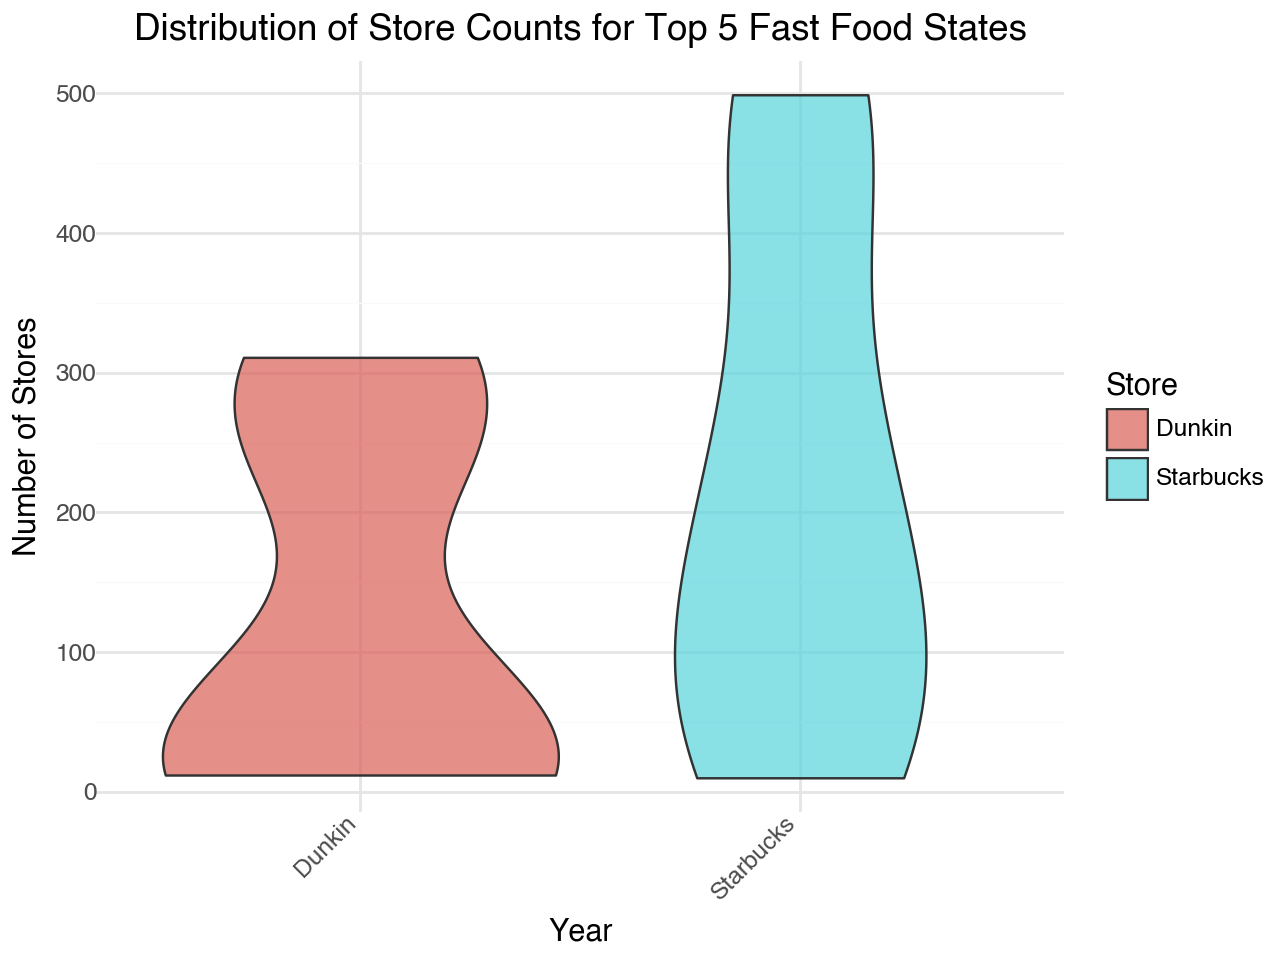

In [44]:
#states with highest fast food consumption
states_of_interest = ["Louisiana", "Mississippi", "Ohio", "Maryland", "Kentucky"]
filtered_df = merged_df[merged_df['State'].isin(states_of_interest)]

# Create the violin plot
(ggplot(filtered_df, aes(x='Store', y='Count', fill='Store'))
     + geom_violin(alpha=0.7, position=position_dodge(width=0.75))
     + labs(title='Distribution of Store Counts for Top 5 Fast Food States',
             x='Year',
             y='Number of Stores')
     + theme_minimal() 
     + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='right'))


### Store Count Distribution by State with Violin Plot

The violin plot for the United States highest fast-food consumption states (Louisiana, Mississippi, Ohio, Maryland, and Kentucky) offers further insight into store count distribution for each chain:

Dunkin' has a shorter and wider shape, resembling a guitar body shape, suggesting lower median store counts with greater variability within each of these states. This shape shows that Dunkin’ might have fewer but more dispersed stores, catering to localized areas.

Starbucks, by contrast, is taller and narrower at the top with a wide base, indicating a more consistent presence and higher median store counts. The narrow shape at the top suggests that there are fewer very high or very low values, with Starbucks maintaining a strong, more uniform presence across these states.

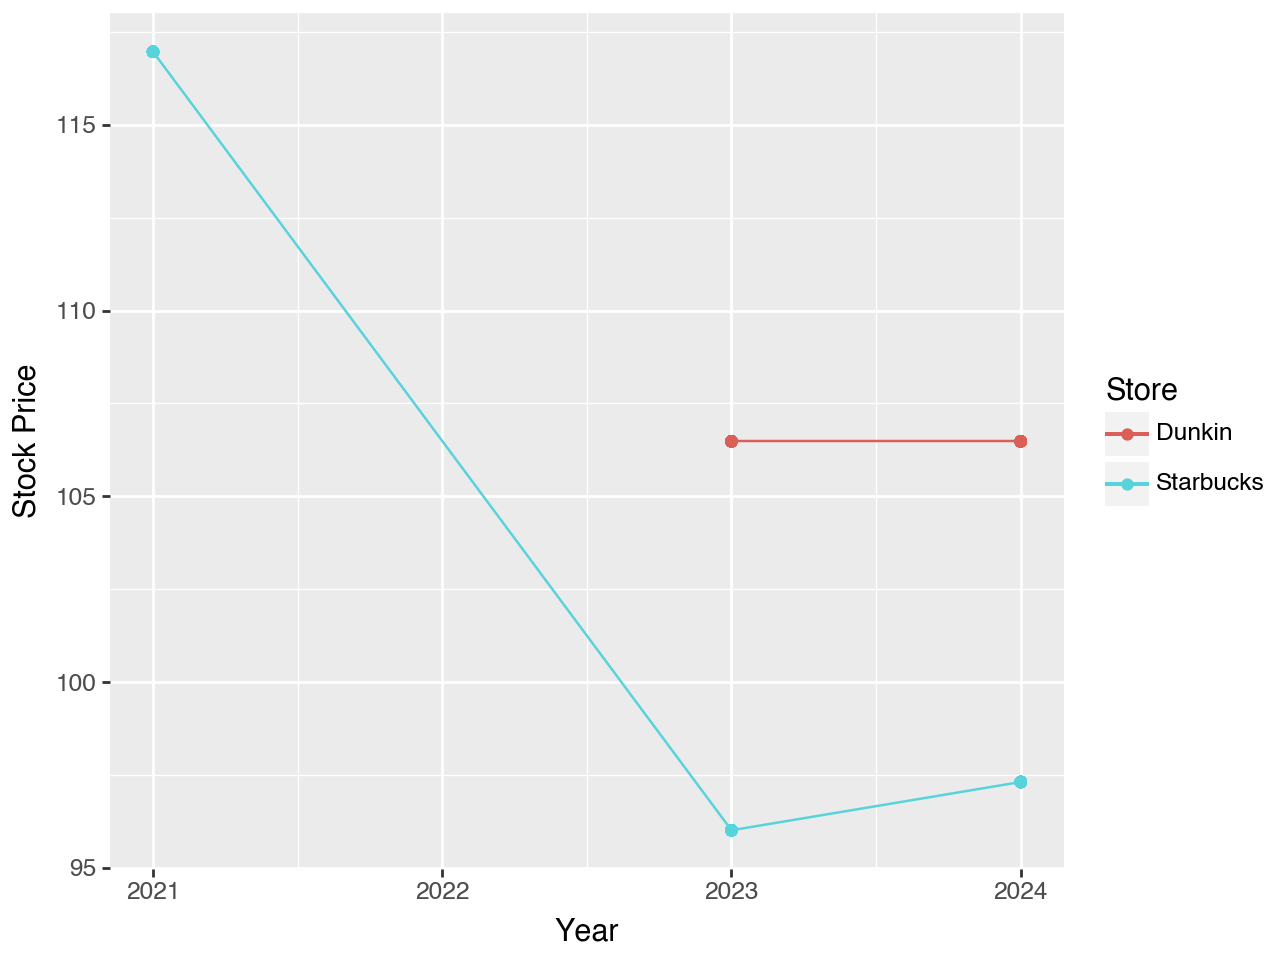

In [45]:
merged_df['Year'] = pd.to_numeric(merged_df['Year'], errors='coerce')
(ggplot(merged_df, aes(x="Year", y="Stock Price", color="Store")) 
    + geom_point()
    + geom_line()
)

### Stock Price Trends by Year and Store

The line plot of stock prices for Starbucks and Dunkin' over the available years highlights some key financial insights:

Starbucks’ stock price dropped from 2021 to 2023 but recovered slightly by 2024. This could reflect general market fluctuations, brand adjustments, or impacts of expansion efforts as seen in the store count increase.

Dunkin’ only has stock price data for one year (approximately $106), so it’s challenging to compare, but this value provides a benchmark. 

The fluctuation in Starbucks’ stock price, despite increasing store counts, suggests that market conditions or broader economic trends are likely influencing the stock independently of just store expansion.

The line plot of stock prices reveals that Starbucks experienced a decline from 2021 to 2023 but showed a slight recovery in 2024. This fluctuation may reflect broader market trends or could be attributed to the Covid-19 Pandemic when many restaurants were still limited with regards to their hours and allowed customers.

# References and Appendix
- https://finance.yahoo.com/quote/SBUX/
- https://www.investing.com/equities/dunkin-brands-group-chart
- https://finance.yahoo.com/news/20-states-highest-fast-food-131446589.html

AI Statement:

AI tools were used to streamline and enhance various aspects of this lab. Specifically, AI assistance was used to create the region dictionary, which categorized different states into respective regions. Throughout the lab, I relied on AI to troubleshoot and resolve coding errors efficiently, allowing me to address issues more quickly and focus on refining the project. Additionally, AI provided recommendations for data visualization, helping me choose appropriate plot types and aesthetics to communicate insights more effectively. Finally, AI was instrumental in developing a versatile web scraping function, converting the original code into a reusable function capable of gathering data from any store page on the World Population Review website.
